### **Masked Softmax Operation**

One of the most popular applications of the attention mechanism is to sequence models. Hence we need to be able to deal with sequences of different lengths. In some cases, such sequences may end up in the same minibatch, necessitating padding with dummy tokens for shorter sequences. These special tokens do not carry meaning. For instance, assume that we have the following three sentences:

```
Dive  into  Deep    Learning
Learn to    code    <blank>
Hello world <blank> <blank>
```

Since we do not want blanks in our attention model we simply need to limit $\sum_{i=1}^n \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ to $\sum_{i=1}^l \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i$ for however long $l \leq n$ the actual sentence is. Since it is such a common problem, it has a name: the *masked softmax operation*.

Let's implement it. Actually, the implementation cheats ever so slightly by setting the values to zero $\mathbf{v}_i = 0$ for $i > l$. Moreover, it sets the attention weights to a large negative number, such as $-10^{6}$ in order to make their contribution to gradients and values vanish in practice. This is done since linear algebra kernels and operators are heavily optimized for GPUs and it is faster to be slightly wasteful in computation rather than to have code with conditional (if then else) statements.

In [24]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt

In [5]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor

    def _sequence_mask(X, valid_len, value=0):
        # Create a mask to hide elements beyond the valid length of each sequence
        maxlen = X.size(1)  # Maximum sequence length
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        # The mask is a boolean tensor where each element is True if it is within
        # the valid length and False otherwise.

        X[~mask] = value
        # Set elements outside the valid length to the given value
        return X

    if valid_lens is None:
        # If valid_lens is not provided, perform regular softmax along the last axis
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            # If valid_lens is 1D, repeat it to match the length of each sequence in X
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            # If valid_lens is 2D, reshape it to 1D for further processing
            valid_lens = valid_lens.reshape(-1)

        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        # Reshape X to a 2D tensor to apply the sequence mask
        # Replace masked elements with a very large negative value (-1e6 in this case)

        return nn.functional.softmax(X.reshape(shape), dim=-1)
        # Reshape X back to its original shape and apply softmax along the last axis


To illustrate how this function works,
consider a minibatch of two examples of size $2 \times 4$,
where their valid lengths are $2$ and $3$, respectively.
As a result of the masked softmax operation,
values beyond the valid lengths for each pair of vectors are all masked as zero.

In [9]:
inputs = torch.rand(2, 2, 4)

print("inputs: \n", inputs)

outputs = masked_softmax(inputs, torch.tensor([2, 3]))

print("outputs: \n", outputs)

inputs: 
 tensor([[[0.1407, 0.1641, 0.8327, 0.5329],
         [0.1548, 0.6987, 0.3862, 0.0199]],

        [[0.4034, 0.6312, 0.7516, 0.6110],
         [0.5422, 0.1894, 0.3234, 0.7037]]])
outputs: 
 tensor([[[0.4942, 0.5058, 0.0000, 0.0000],
         [0.3673, 0.6327, 0.0000, 0.0000]],

        [[0.2723, 0.3420, 0.3857, 0.0000],
         [0.3990, 0.2804, 0.3206, 0.0000]]])


### **Dot product attention**

As we saw in the slides, the most commonly usted attention function is the dot product attention. The Transofmer architecture, for example, uses this function.

$$ a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^\top \mathbf{k}_i / \sqrt{d}.$$

Note that attention weights $\alpha$ still need normalizing. We can simplify this further by using the softmax operation:

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1} \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}.$$

As it turns out, all popular attention mechanisms use the softmax, hence we will limit ourselves to that in the remainder of this chapter.

### **Scaled Dot-Product Attention**

In general, dot product attention requires that both the query and the key
have the same vector length, say $d$, even though this can be addressed easily by replacing
$\mathbf{q}^\top \mathbf{k}$ with $\mathbf{q}^\top \mathbf{M} \mathbf{k}$ where $\mathbf{M}$ is a suitably chosen matrix to translate between both spaces. For now assume that the dimensions match.

In practice, we often think in minibatches for efficiency,
such as computing attention for $n$ queries and $m$ key-value pairs,
where queries and keys are of length $d$
and values are of length $v$. The scaled dot-product attention
of queries $\mathbf Q\in\mathbb R^{n\times d}$,
keys $\mathbf K\in\mathbb R^{m\times d}$,
and values $\mathbf V\in\mathbb R^{m\times v}$
thus can be written as

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$


In [11]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

To illustrate how the `DotProductAttention` class works,
we use the same keys, values, and valid lengths from the earlier toy example for additive attention. For the purpose of our example we assume that we have a minibatch size of $2$, a total of $10$ keys and values, and that the dimensionality of the values is $4$. Lastly, we assume that the valid length per observation is $2$ and $6$ respectively. Given that, we expect the output to be a $2 \times 1 \times 4$ tensor, i.e., one row per example of the minibatch.

In [46]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
result = attention(queries, keys, values, valid_lens)

print("Queries: \n", queries)
print("Keys: \n", keys)
print("Values: \n", values)
print("Attention: \n", result)

Queries: 
 tensor([[[-0.4769,  0.0767]],

        [[-0.9069, -2.1396]]])
Keys: 
 tensor([[[ 0.8952, -0.3398],
         [-0.6138, -1.1853],
         [-0.0580, -0.9534],
         [ 0.7163, -0.4202],
         [ 0.0392, -0.2918],
         [ 0.1016,  1.9773],
         [-0.4075, -0.7910],
         [-0.9161, -1.4443],
         [-0.1743, -0.6954],
         [ 0.9262,  0.8130]],

        [[ 0.4664, -0.1630],
         [ 0.0741, -0.6632],
         [-0.5271,  0.1814],
         [-0.6045, -1.2233],
         [-0.3808, -0.9380],
         [-1.5337, -0.3351],
         [ 0.3644, -0.3963],
         [ 1.1783, -0.1817],
         [ 0.0515,  0.2844],
         [ 2.0289,  0.7141]]])
Values: 
 tensor([[[ 0.2942, -0.4020, -0.5634, -0.3054],
         [-0.5737, -0.4451,  0.8650, -0.0489],
         [ 1.2851, -1.1714, -1.2921, -0.4575],
         [-2.5114, -0.3754,  0.7416, -1.9930],
         [ 1.7461,  0.8201, -0.6513,  0.2012],
         [-0.8487,  0.9756,  0.3937,  1.2326],
         [ 1.5037, -1.1476,  0.5260,  1.073

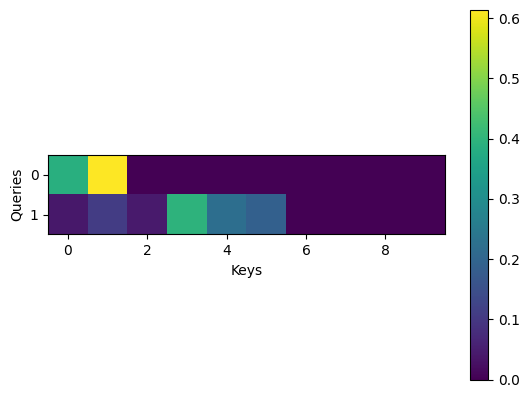

In [47]:
plt.imshow(attention.attention_weights.reshape((1, 1, 2, 10))[0][0])
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.colorbar()
plt.show()

## **Additive Attention**

When queries $\mathbf{q}$ and keys $\mathbf{k}$ are vectors of different dimensionalities,
we can either use a matrix to address the mismatch via $\mathbf{q}^\top \mathbf{M} \mathbf{k}$, or we can use additive attention
as the scoring function. Another benefit is that, as its name indicates, the attention is additive. This can lead to some minor computational savings.
Given a query $\mathbf{q} \in \mathbb{R}^q$
and a key $\mathbf{k} \in \mathbb{R}^k$,
the *additive attention* scoring function `Bahdanau.Cho.Bengio.2014` is given by

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$

where $\mathbf W_q\in\mathbb R^{h\times q}$, $\mathbf W_k\in\mathbb R^{h\times k}$,
and $\mathbf w_v\in\mathbb R^{h}$ are the learnable parameters. This term is then fed into a softmax to ensure both nonnegativity and normalization.
An equivalent interpretation of additive attention is that the query and key are concatenated
and fed into an MLP with a single hidden layer.
Using $\tanh$ as the activation function and disabling bias terms,
we implement additive attention as follows:

In [30]:
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys) # Multiply q and k by W_q and W_k respectively
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

Let's see how `AdditiveAttention` works. In our toy example we pick queries, keys and values of size
$(2, 1, 20)$, $(2, 10, 2)$ and $(2, 10, 4)$, respectively. This is identical to our choice for `DotProductAttention`, except that now the queries are $20$-dimensional. Likewise, we pick $(2, 6)$ as the valid lengths for the sequences in the minibatch.


In [42]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
result =  attention(queries, keys, values, valid_lens)

print("Queries: \n", queries)
print("Keys: \n", keys)
print("Values: \n", values)
print("Attention: \n", result)

Queries: 
 tensor([[[ 2.8242e-01, -1.3962e-03, -7.0349e-01,  1.7756e+00,  1.4052e+00,
          -1.2181e+00,  3.9631e-01,  1.9083e-01, -1.5812e-01, -8.6474e-01,
           1.6821e+00,  6.5666e-01,  1.2068e+00, -7.3753e-01, -8.5977e-01,
           1.0366e+00,  3.6275e-01,  2.5142e-01,  4.1146e-01,  2.8372e-01]],

        [[-9.1970e-01, -6.5700e-01,  1.2596e+00, -5.9799e-01, -1.7267e+00,
          -1.0618e+00, -2.0498e+00,  2.2901e-01,  1.3242e+00,  5.2288e-02,
          -2.7197e-01, -4.3482e-01, -5.0288e-01,  1.8314e+00,  1.7466e+00,
           1.8451e+00, -1.1207e+00, -2.3970e+00,  3.7826e-01,  8.3246e-01]]])
Keys: 
 tensor([[[-0.2237,  0.9021],
         [-0.7794, -0.6298],
         [ 0.8779, -0.3270],
         [ 0.3462,  1.1085],
         [ 1.1632, -0.7229],
         [ 0.0936,  0.5109],
         [-0.6768,  1.0099],
         [-2.1561,  0.4883],
         [ 1.3244,  1.0699],
         [-0.9406,  1.7271]],

        [[ 1.6498,  0.5630],
         [ 0.1741,  2.1395],
         [ 0.5577, -0.633

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


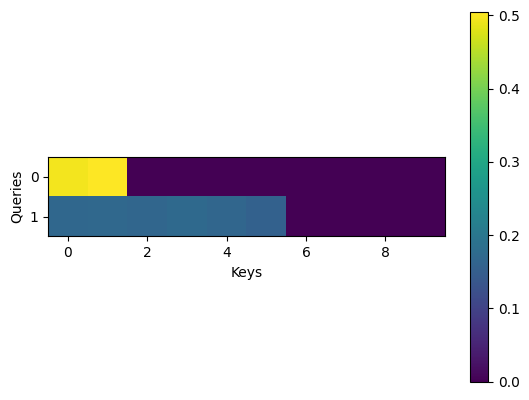

In [43]:
plt.imshow(attention.attention_weights.reshape((1, 1, 2, 10)).detach()[0][0])
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.colorbar()
plt.show()